# Импорты

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy

import cvxpy 
import array_to_latex as a2l

In [3]:
sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I

In [4]:
np.set_printoptions(precision=2)

In [5]:
def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

# Задание 1

In [6]:
def get_controllability_matrix(A, B):
    ctrb_m = np.hstack((B, *[(np.linalg.matrix_power(A, i)) @ B for i in range(1, A.shape[0])]))
    assert np.allclose(control.ctrb(A, B), ctrb_m), 'Smth wrong'
    return ctrb_m

def get_observability_matrix(A, C):
    obsv_m = np.vstack((C, *[C @ np.linalg.matrix_power(A, i) for i in range(1, A.shape[0])]))
    assert np.allclose(control.obsv(A, C), obsv_m), 'Smth wrong'
    return obsv_m

def check_controllability(A, B):
    U = get_controllability_matrix(A, B)
    print(f'RankU = {np.linalg.matrix_rank(U)}')
    return np.linalg.matrix_rank(U) == A.shape[0]
        
def check_controllability_eigens(A, B):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'controllable' if np.linalg.matrix_rank(np.hstack(((A - val * np.eye(A.shape[0])), B))) == A.shape[0] else 'not controllable'}")

def check_observability(C, A):
    V = get_observability_matrix(A, C)
    print(f'RankV = {np.linalg.matrix_rank(V)}')
    return np.linalg.matrix_rank(V) == A.shape[0]

def check_observability_eigens(C, A):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'observable' if np.linalg.matrix_rank(np.vstack(((A - val * np.eye(A.shape[0])), C))) == A.shape[0] else 'not observable'}")

In [7]:
task1_A = np.array([
    [-4, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 5],
    [0, 0, -5, 1]
])

task1_B = np.array([
    [0], 
    [2], 
    [0], 
    [9]
])

task1_x0 = np.array([1, 1, 1, 1])

task1_alphas = np.array([0.000001, 0.1, 1, 4])

In [8]:
check_controllability_eigens(task1_A, task1_B)

Eigen values of A:
   [1.+5.j]: controllable
   [1.-5.j]: controllable
   [-4.+0.j]: not controllable
   [1.+0.j]: controllable


In [9]:
def task1_simulate(A, B, K, x0, ts):
    print(f'spec(A + B@K): {np.linalg.eigvals(A + B@K)}; stable: {np.all(np.linalg.eigvals(A + B@K).real < 0)}')
    a2l.to_ltx(np.linalg.eigvals(A + B@K))
    ss = control.ss(A + B@K, A*0, A*0, A*0)
    return control.forced_response(ss, X0=x0, T=ts)

In [10]:
def task1_get_K(A, B, alpha):
    P = cvxpy.Variable(A.shape, PSD=True)
    Y = cvxpy.Variable((B.shape[1], B.shape[0]))
    lyapunov_lmi = P @ A.T + A @ P + 2 * alpha * P + Y.T @ B.T + B @ Y
    
    constraints = [P >> np.eye(4) , lyapunov_lmi << 0]
    objective = cvxpy.Minimize(0)
    
    prob = cvxpy.Problem(objective, constraints)
    print(f'Optimization error: {prob.solve(solver="CVXOPT")}')
    print(f'spec(P): {np.linalg.eigvals(P.value)}; P >> 0: {np.all(np.linalg.eigvals(P.value).real >= 0)}')
    print(f'spec(lmi): {np.linalg.eigvals(lyapunov_lmi.value)}; lyapunov_lmi <<= 0: {np.all(np.linalg.eigvals(lyapunov_lmi.value).real <= 0)}')
    print(P.value)
    
    return Y.value @ np.linalg.pinv(P.value), True

In [11]:
task1_reses = dict()
ts = get_t(10)
for alpha in task1_alphas:
    print(f'========   {alpha = }   =========')
    K, status = task1_get_K(task1_A, task1_B, alpha)
    if not status:
        print(':(')
        continue
    print(f'{K = }')
    task1_reses[alpha] = (task1_simulate(task1_A, task1_B, K, task1_x0, ts), K)

========   alpha = 1e-06   =========
Optimization error: 0.0
spec(P): [ 3.72  3.05 13.08 29.71]; P >> 0: True
spec(lmi): [-29.74 -12.98 -10.23  -3.07]; lyapunov_lmi <<= 0: True
[[ 3.72e+00  1.93e-16  3.11e-16  7.98e-16]
 [ 1.93e-16  8.74e+00 -1.03e+01  2.39e+00]
 [ 3.11e-16 -1.03e+01  2.16e+01 -5.35e+00]
 [ 7.98e-16  2.39e+00 -5.35e+00  1.54e+01]]
K = array([[-1.78e-16, -8.07e-01, -2.45e-01, -3.09e-01]])
spec(A + B@K): [-0.57+5.44j -0.57-5.44j -0.26+0.j   -4.  +0.j  ]; stable: True
\begin{bmatrix}
 -0.57 + 5.44j & -0.57 + -5.44j & -0.26 + 0.00j & -4.00 + 0.00j
\end{bmatrix}
========   alpha = 0.1   =========
Optimization error: 0.0
spec(P): [ 4.11  2.91 14.27 33.2 ]; P >> 0: True
spec(lmi): [-32.05  -3.05 -14.24 -11.07]; lyapunov_lmi <<= 0: True
[[ 4.11e+00 -4.25e-16 -1.01e-15 -1.07e-15]
 [-4.25e-16  8.83e+00 -1.12e+01  2.96e+00]
 [-1.01e-15 -1.12e+01  2.41e+01 -6.41e+00]
 [-1.07e-15  2.96e+00 -6.41e+00  1.74e+01]]
K = array([[-2.51e-16, -9.12e-01, -2.89e-01, -3.22e-01]])
spec(A + B@K)

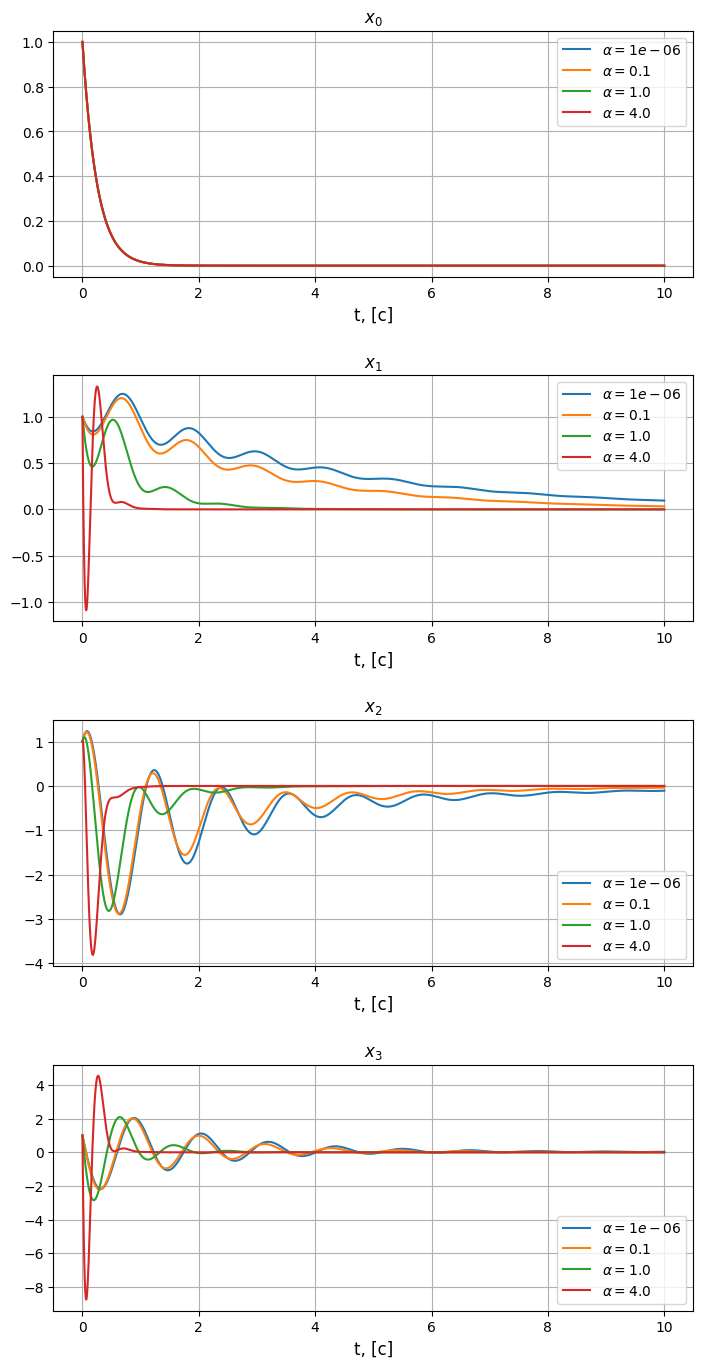

In [12]:
fig, axs = plt.subplots(4, figsize=(8, 16))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for indx, alpha in enumerate(task1_reses):
    res, _ = task1_reses[alpha]
    for i, state in enumerate(res.states):
        axs[i].plot(ts, state, label=f"$\\alpha = {alpha}$") 
for i in range(4):
    axs[i].set_xlabel(f"t, [c]", fontsize=12)
    axs[i].set_title(f"$x_{i}$", fontsize=12)
    axs[i].grid(True)
    axs[i].legend()

[-0.57+5.44j -0.57-5.44j -0.26+0.j   -4.  +0.j  ]
[-0.68+5.53j -0.68-5.53j -0.36+0.j   -4.  +0.j  ]
[-1.84+6.77j -1.84-6.77j -1.39+0.j   -4.  +0.j  ]
[-7.81+13.56j -7.81-13.56j -5.59 +0.j   -4.   +0.j  ]


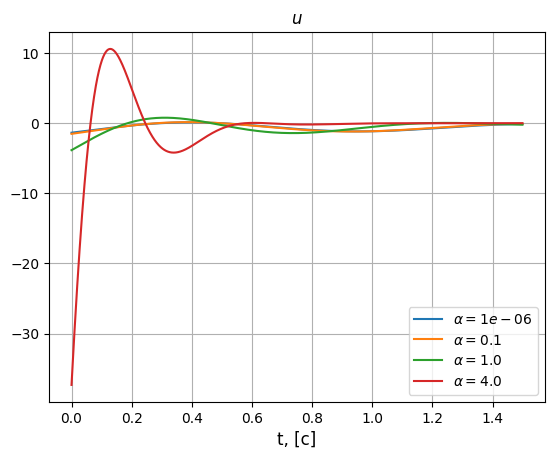

In [13]:
task1_table = []
for indx, alpha in enumerate(task1_reses):
    res, K = task1_reses[alpha]
    print(np.linalg.eigvals(task1_A + task1_B @ K))
    task1_table.append([alpha, K, np.linalg.eigvals(task1_A + task1_B @ K)])
    us = K @ res.states
    plt.plot(ts[:len(ts)//100 * 15], us[0, :len(ts)//100 * 15], label=f"$\\alpha = {alpha}$") 
plt.xlabel(f"t, [c]", fontsize=12)
plt.title(f"$u$", fontsize=12)
plt.grid(True)
plt.legend()

# Задание 2

In [14]:
def task2_get_K_with_constraint(A, B, x, alpha, mu):
    P = cvxpy.Variable(A.shape, PSD=True)
    Y = cvxpy.Variable((B.shape[1], B.shape[0]))
    lyapunov_lmi = P @ A.T + A @ P + 2 * alpha * P + Y.T @ B.T + B @ Y

    new_const1 = cvxpy.bmat([[P, x], [x.T, np.ones((1, 1))]])
    new_const2 = cvxpy.bmat([[P, Y.T], [Y, (mu**2) * np.identity(B.shape[1])]])
    
    constraints = [P >> np.eye(4) , lyapunov_lmi << 0, new_const1 >> 0, new_const2 >> 0]
    objective = cvxpy.Minimize(0)
    prob = cvxpy.Problem(objective, constraints)
    
    try:
        print(f'Optimization error: {prob.solve(solver="CVXOPT")}')
        print(f'spec(P): {np.linalg.eigvals(P.value)}; P >> 0: {np.all(np.linalg.eigvals(P.value).real >= 0)}')
        print(f'spec(lmi): {np.linalg.eigvals(lyapunov_lmi.value)}; lyapunov_lmi <<= 0: {np.all(np.linalg.eigvals(lyapunov_lmi.value).real <= 0)}')
    except Exception:
        return 0, False
    
    
    return Y.value @ np.linalg.pinv(P.value), True

def task2_get_K_min(A, B, x, alpha):
    mumu = cvxpy.Variable((1, 1))
    P = cvxpy.Variable(A.shape, PSD=True)
    Y = cvxpy.Variable((B.shape[1], B.shape[0]))
    lyapunov_lmi = P @ A.T + A @ P + 2 * alpha * P + Y.T @ B.T + B @ Y
    new_const1 = cvxpy.bmat([[P, x], [x.T, np.ones((1, 1))]])
    new_const2 = cvxpy.bmat([[P, Y.T], [Y, mumu @ np.identity(B.shape[1])]])
    
    constraints = [P >> np.eye(4), lyapunov_lmi << 0, new_const1 >> 0, new_const2 >> 0]
    objective = cvxpy.Minimize(mumu)
    prob = cvxpy.Problem(objective, constraints)
    try:
        print(f'Optimization error: {prob.solve(solver="CVXOPT")}')
    except Exception:
        return (0, 0, False)
    return np.sqrt(mumu.value)[0][0], Y.value @ np.linalg.pinv(P.value), True


In [15]:
task2_reses1 = dict()
task2_alpha = 1
min_mu, min_K, valid = task2_get_K_min(task1_A, task1_B, task1_x0.reshape(4, 1), task2_alpha)
ts = get_t(5)
for mu in [3.1, 3.1 * 2, 3.1 * 5]:
    print(f'========   {mu = }   =========')
    K, status = task2_get_K_with_constraint(task1_A, task1_B, task1_x0.reshape(4, 1), task2_alpha, mu)
    print(f"K: \n {K}")
    if not status:
        print(':(')
        continue
    task2_reses1[mu] = (task1_simulate(task1_A, task1_B, K, task1_x0, ts), K)

Optimization error: 9.500734593363296
========   mu = 3.1   =========
Optimization error: 0.0
spec(P): [ 1.52 32.19 47.76 19.44]; P >> 0: True
spec(lmi): [-1.93e+02 -1.58e-01 -8.90e-02 -3.53e-03]; lyapunov_lmi <<= 0: True
K: 
 [[ 0.03 -1.39 -0.39 -0.36]]
spec(A + B@K): [-1.01+5.5j -1.01-5.5j -1.02+0.j  -4.  +0.j ]; stable: True
\begin{bmatrix}
 -1.01 + 5.50j & -1.01 + -5.50j & -1.02 + 0.00j & -4.00 + 0.00j
\end{bmatrix}
========   mu = 6.2   =========
Optimization error: 0.0
spec(P): [61.26  1.85  8.37 23.9 ]; P >> 0: True
spec(lmi): [-49.59 -12.84  -6.16  -0.69]; lyapunov_lmi <<= 0: True
K: 
 [[ 0.26 -1.97 -0.68 -0.3 ]]
spec(A + B@K): [-1.26+6.36j -1.26-6.36j -1.16+0.j   -4.  +0.j  ]; stable: True
\begin{bmatrix}
 -1.26 + 6.36j & -1.26 + -6.36j & -1.16 + 0.00j & -4.00 + 0.00j
\end{bmatrix}
========   mu = 15.5   =========
Optimization error: 0.0
spec(P): [ 7.95  1.73 23.9  58.42]; P >> 0: True
spec(lmi): [-47.22  -0.62  -5.81 -11.86]; lyapunov_lmi <<= 0: True
K: 
 [[ 0.44 -2.38 -0.89 

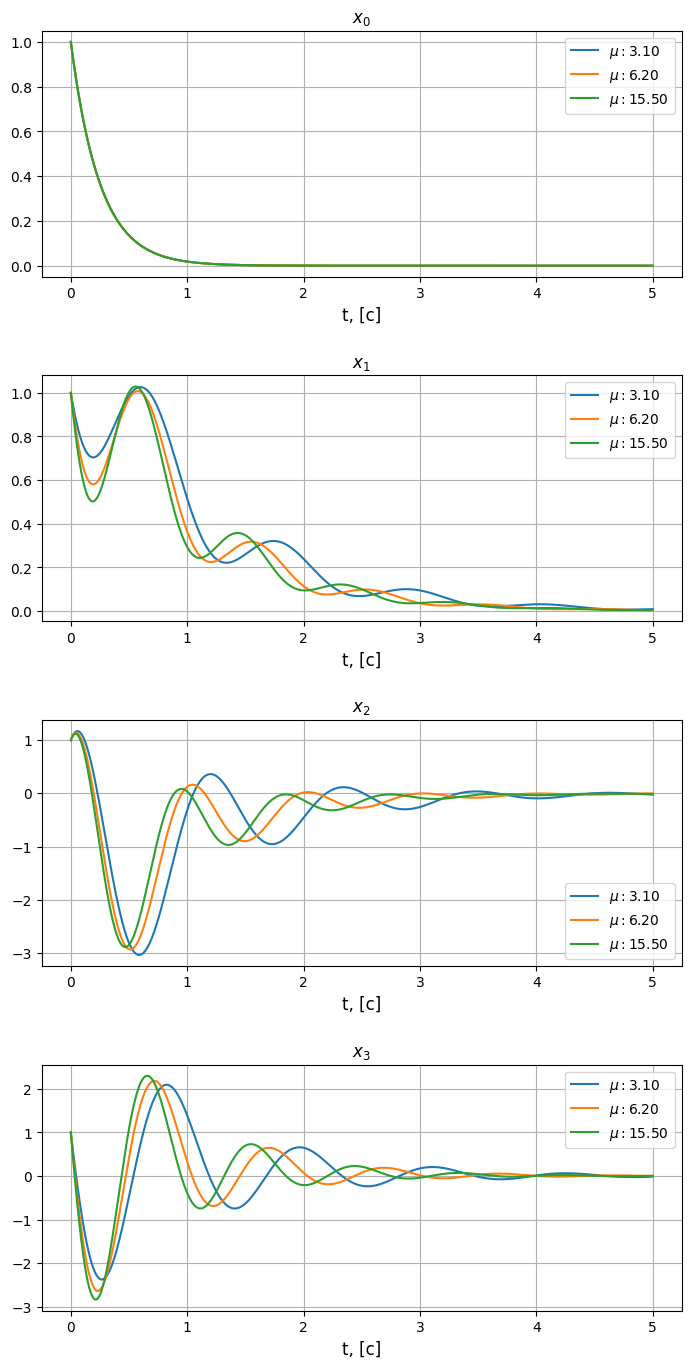

In [20]:
ig, axs = plt.subplots(4, figsize=(8, 16))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for indx, mu in enumerate(task2_reses1):
    res, _ = task2_reses1[mu]
    for i, state in enumerate(res.states):
        axs[i].plot(ts, state, label=f"$\mu: {mu : .2f}$") 
for i in range(4):
    axs[i].set_xlabel(f"t, [c]", fontsize=12)
    axs[i].set_title(f"$x_{i}$", fontsize=12)
    axs[i].grid(True)
    axs[i].legend()

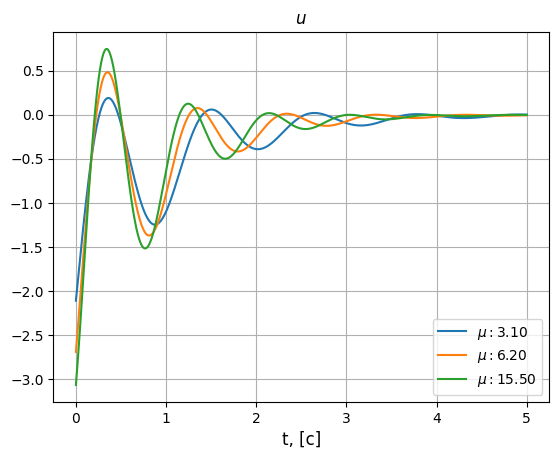

In [21]:
for indx, mu in enumerate(task2_reses1):
    res, K = task2_reses1[mu]
    us = K @ res.states
    plt.plot(ts, us[0], label=f"$\mu: {mu : .2f}$") 
plt.xlabel(f"t, [c]", fontsize=12)
plt.title(f"$u$", fontsize=12)
plt.grid(True)
plt.legend()

In [26]:
task2_reses2 = dict()
task2_table = []
ts = get_t(10)
for alpha in task1_reses:
    print(f'========   {alpha = }   =========')
    min_mu, K, val = task2_get_K_min(task1_A, task1_B, task1_x0.reshape(4, 1), alpha)
    print(f"{min_mu =}")
    print(f"K: \n {K}")
    if not val:
        print(':(')
        continue
    task2_table.append([alpha, K, np.linalg.eigvals(task1_A + task1_B @ K)])
    task2_reses2[(alpha, min_mu)] = (task1_simulate(task1_A, task1_B, K, task1_x0, ts), K)

========   alpha = 1e-06   =========
Optimization error: 1.2111515738741339
min_mu =1.1005233181873675
K: 
 [[ 4.20e-07 -5.45e-01 -9.42e-02 -2.12e-01]]
spec(A + B@K): [-1.26e-06+5.12j -1.26e-06-5.12j -1.27e-06+0.j   -4.00e+00+0.j  ]; stable: True
\begin{bmatrix}
 -0.00 + 5.12j & -0.00 + -5.12j & -0.00 + 0.00j & -4.00 + 0.00j
\end{bmatrix}
========   alpha = 0.1   =========
Optimization error: 1.5648990527481823
min_mu =1.2509592530327207
K: 
 [[ 4.88e-07 -6.10e-01 -1.14e-01 -2.31e-01]]
spec(A + B@K): [-0.1+5.15j -0.1-5.15j -0.1+0.j   -4. +0.j  ]; stable: True
\begin{bmatrix}
 -0.10 + 5.15j & -0.10 + -5.15j & -0.10 + 0.00j & -4.00 + 0.00j
\end{bmatrix}
========   alpha = 1.0   =========
Optimization error: 9.500734593363296
min_mu =3.082326165960263
K: 
 [[ 1.94e-06 -1.37e+00 -3.84e-01 -3.62e-01]]
spec(A + B@K): [-1.+5.5j -1.-5.5j -1.+0.j  -4.+0.j ]; stable: True
\begin{bmatrix}
 -1.00 + 5.50j & -1.00 + -5.50j & -1.00 + 0.00j & -4.00 + 0.00j
\end{bmatrix}
========   alpha = 4.0   ======

0 (1e-06, 1.1005233181873675)
1 (0.1, 1.2509592530327207)
2 (1.0, 3.082326165960263)


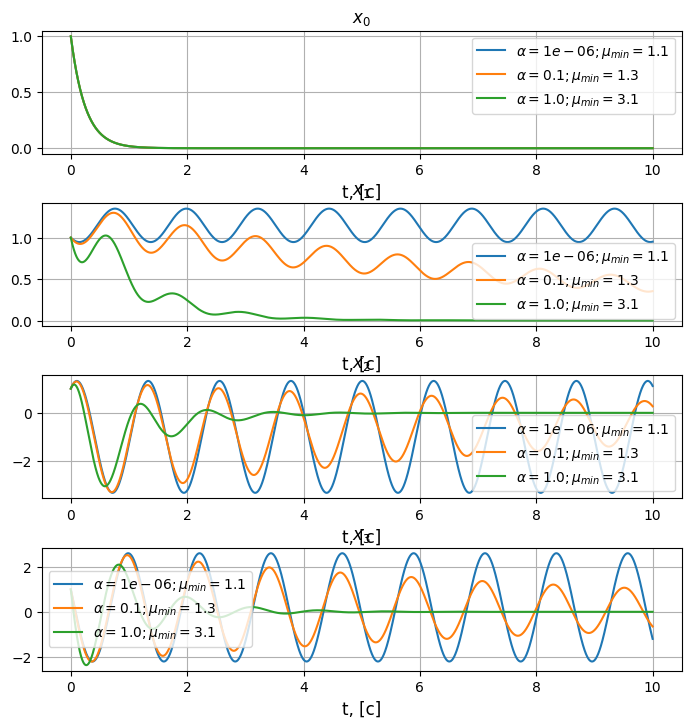

In [30]:
fig, axs = plt.subplots(4, figsize=(8, 8))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for indx, key in enumerate(task2_reses2):
    print(indx, key)
    res, _ = task2_reses2[list(task2_reses2.keys())[indx]]
    alpha, min_mu = key
    for i, state in enumerate(res.states):
        axs[i].plot(ts, state, label=f"$\\alpha = {alpha}; $" "$\\mu_{min}$" f"$= {min_mu: .1f}$") 
for i in range(4):
    axs[i].set_xlabel(f"t, [c]", fontsize=12)
    axs[i].set_title(f"$x_{i}$", fontsize=12)
    axs[i].grid(True)
    axs[i].legend()

In [24]:
for alpha, k, eig in task2_table:
    print('\\[')
    print(f'\\alpha = {alpha}; ')
    
    k_str = a2l.to_ltx(k.T, print_out=False)
    print(f'K = {k_str};')
    
    eig_str = a2l.to_ltx(eig.reshape(-1, 1), print_out=False)
    print(f'\\sigma(A+BK) = {eig_str};')
    print('\\]')

\[
\alpha = 1e-06; 
K = \begin{bmatrix}
  0.00\\
 -0.54\\
 -0.09\\
 -0.21
\end{bmatrix};
\sigma(A+BK) = \begin{bmatrix}
 -0.00 + 5.12j\\
 -0.00 + -5.12j\\
 -0.00 + 0.00j\\
 -4.00 + 0.00j
\end{bmatrix};
\]
\[
\alpha = 0.1; 
K = \begin{bmatrix}
  0.00\\
 -0.61\\
 -0.11\\
 -0.23
\end{bmatrix};
\sigma(A+BK) = \begin{bmatrix}
 -0.10 + 5.15j\\
 -0.10 + -5.15j\\
 -0.10 + 0.00j\\
 -4.00 + 0.00j
\end{bmatrix};
\]
\[
\alpha = 1.0; 
K = \begin{bmatrix}
  0.00\\
 -1.37\\
 -0.38\\
 -0.36
\end{bmatrix};
\sigma(A+BK) = \begin{bmatrix}
 -1.00 + 5.50j\\
 -1.00 + -5.50j\\
 -1.00 + 0.00j\\
 -4.00 + 0.00j
\end{bmatrix};
\]


# Задание 3

In [75]:
task3_A = np.array([
    [0, 4, 0, 0],
    [-4, 0, 0, 0],
    [0, 0, 0, 3],
    [0, 0, -3, 0]
])

task3_C = np.array([[5, 0, 0, 9]])

task3_specs = np.array([
    [-4, -4, -4, -4],
    [-4, -40, -400, -400],
    [-4, -8, 5j, -5j],
    [-4, -8, -1 + 5j, -1 - 5j],
])
task3_alphas = np.array([0.000001, 0.1, 1.0, 4.0])

task3_x0 = np.array([1, 1, 1, 1])
task3_xh0 = np.array([2, 2, 2, 2])

In [76]:
def task3_simulate(A, C, L, x0, xh0, ts):
    print(f'spec(A + LC): {np.linalg.eigvals(A + L @ C)}; stable: {np.all(np.linalg.eigvals(A + L @ C).real < 0)}')
    print(a2l.to_ltx(np.linalg.eigvals(A + L @ C)))
    ss_orig = control.ss(A, np.zeros((A.shape[0], 1)), C, np.zeros((C.shape[0], 1)))
    original_resp = control.forced_response(ss_orig, X0=x0, T=ts)
    ss = control.ss(A + L@C, L, A*0, L*0)
    return original_resp, control.forced_response(ss, X0=xh0, T=ts, U=-original_resp.outputs.reshape(-1))


def task3_get_L(A, C, alpha):
    Q = cvxpy.Variable(A.shape, PSD=True)
    Y = cvxpy.Variable((C.shape[1], C.shape[0]))
    
    lyapunov_lmi = A.T @ Q + Q @ A + 2 * alpha * Q + C.T @ Y.T + Y @ C
    constraints = [Q >> np.eye(4) , lyapunov_lmi << 0]
    objective = cvxpy.Minimize(0)
    
    prob = cvxpy.Problem(objective, constraints)
    try:
        # print(f'Optimization error: {prob.solve(solver="CVXOPT")}')
        print(f'Optimization error: {prob.solve()}')
        
        print(f'spec(P): {np.linalg.eigvals(Q.value)}; Q >> 0: {np.all(np.linalg.eigvals(Q.value).real >= 0)}')
        print(f'spec(lmi): {np.linalg.eigvals(lyapunov_lmi.value)}; lyapunov_lmi <<= 0: {np.all(np.linalg.eigvals(lyapunov_lmi.value).real <= 0)}')
        # print(P.value)
    except Exception as e:
        print(e)
        return 0, False
    
    return np.linalg.pinv(Q.value) @ Y.value, True

In [77]:
task3_reses = dict()
task3_table = []
ts = get_t(10)
for alpha in task3_alphas:
    print(f'========   {alpha = }   =========')
    L, status = task3_get_L(task3_A, task3_C, alpha)
    if not status:
        print(':(')
        continue
    task3_table.append([alpha, L, np.linalg.eigvals(task3_A + L @ task3_C)])
    print(f'L.T = {L.T}')
    task3_reses[alpha] = (task3_simulate(task3_A, task3_C, L, task3_x0, task3_xh0, ts), L)

========   alpha = 1e-06   =========
Optimization error: 0.0
spec(P): [1.45 1.45 1.45 1.45]; Q >> 0: True
spec(lmi): [-2.60e-13 -2.64e-06 -2.63e-06 -7.20e-08]; lyapunov_lmi <<= 0: True
L.T = [[-6.80e-07 -1.66e-12 -2.58e-12 -2.72e-07]]
spec(A + LC): [-1.70e-06+4.j -1.70e-06-4.j -1.22e-06+3.j -1.22e-06-3.j]; stable: True
\begin{bmatrix}
 -0.00 + 4.00j & -0.00 + -4.00j & -0.00 + 3.00j & -0.00 + -3.00j
\end{bmatrix}
None
========   alpha = 0.1   =========
Optimization error: 0.0
spec(P): [2.23 2.01 1.08 1.  ]; Q >> 0: True
spec(lmi): [-9.29e-08 -1.09e-02 -1.47e-01 -1.54e-01]; lyapunov_lmi <<= 0: True
L.T = [[-0.05 -0.03  0.01 -0.03]]
spec(A + LC): [-0.14+4.05j -0.14-4.05j -0.12+3.07j -0.12-3.07j]; stable: True
\begin{bmatrix}
 -0.14 + 4.05j & -0.14 + -4.05j & -0.12 + 3.07j & -0.12 + -3.07j
\end{bmatrix}
None
========   alpha = 1.0   =========
Optimization error: 0.0
spec(P): [82797.71 43786.61   329.19  1793.5 ]; Q >> 0: True
spec(lmi): [-3.54e+03 -2.08e+03 -2.67e-04 -8.09e+01]; lyapunov_l

In [78]:
for alpha, l, eig in task3_table:
    print('\\[')
    print(f'\\alpha = {alpha}; ')
    
    l_str = a2l.to_ltx(l, print_out=False)
    print(f'L = {l_str};')
    
    eig_str = a2l.to_ltx(eig.reshape(-1, 1), print_out=False)
    print(f'\\sigma(A+LC) = {eig_str};')
    print('\\]')

\[
\alpha = 1e-06; 
L = \begin{bmatrix}
 -0.00\\
 -0.00\\
 -0.00\\
 -0.00
\end{bmatrix};
\sigma(A+LC) = \begin{bmatrix}
 -0.00 + 4.00j\\
 -0.00 + -4.00j\\
 -0.00 + 3.00j\\
 -0.00 + -3.00j
\end{bmatrix};
\]
\[
\alpha = 0.1; 
L = \begin{bmatrix}
 -0.05\\
 -0.03\\
  0.01\\
 -0.03
\end{bmatrix};
\sigma(A+LC) = \begin{bmatrix}
 -0.14 + 4.05j\\
 -0.14 + -4.05j\\
 -0.12 + 3.07j\\
 -0.12 + -3.07j
\end{bmatrix};
\]
\[
\alpha = 1.0; 
L = \begin{bmatrix}
  2.40\\
 -3.04\\
 -0.38\\
 -2.35
\end{bmatrix};
\sigma(A+LC) = \begin{bmatrix}
 -2.64 + 6.01j\\
 -2.64 + -6.01j\\
 -1.92 + 2.93j\\
 -1.92 + -2.93j
\end{bmatrix};
\]
\[
\alpha = 4.0; 
L = \begin{bmatrix}
  53.51\\
  10.09\\
  18.64\\
 -32.00
\end{bmatrix};
\sigma(A+LC) = \begin{bmatrix}
 -5.35 + 12.62j\\
 -5.35 + -12.62j\\
 -4.89 + 3.17j\\
 -4.89 + -3.17j
\end{bmatrix};
\]


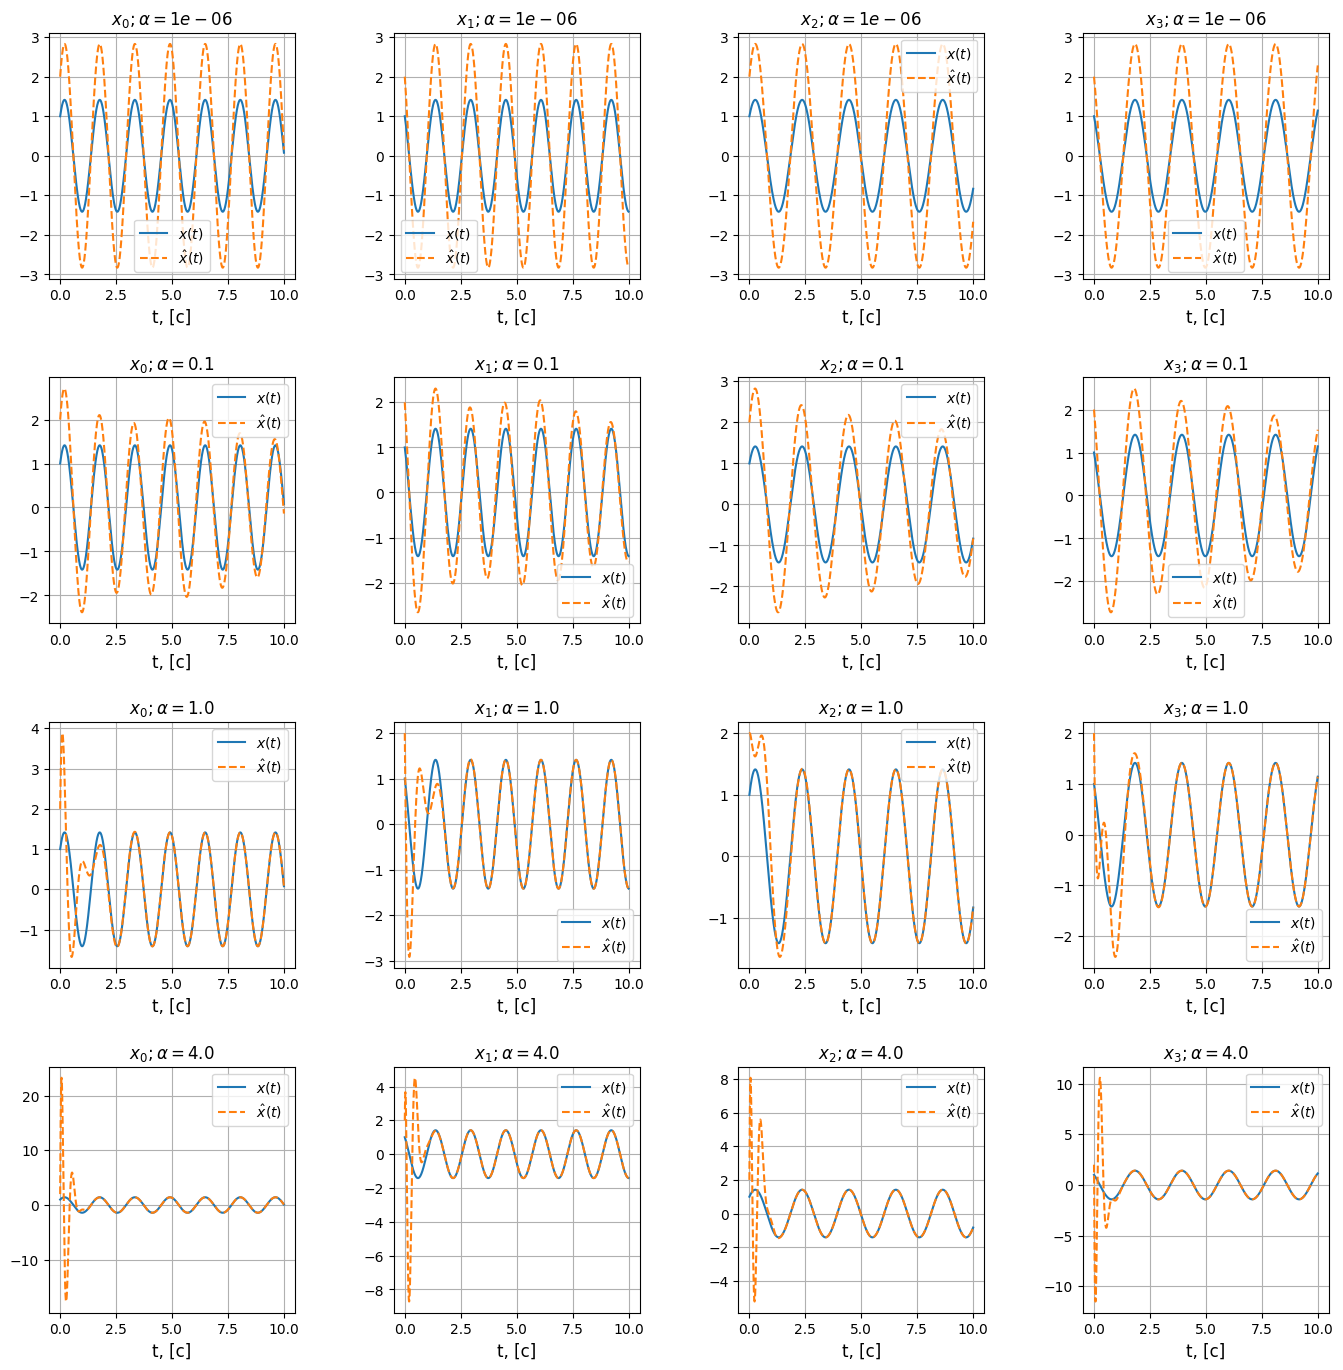

In [81]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
alphas = []
for indx, key in enumerate(task3_reses):
    (orig, obs), L = task3_reses[key]
    alpha = key
    alphas.append(alpha)
    
    for i, state in enumerate(orig.states):
        axs[indx, i].plot(ts, state, label=f"$x(t)$") 
        
    for i, state in enumerate(obs.states):
        axs[indx, i].plot(ts, state, '--', label=f"$\\hat x(t)$") 
    # break
for i in range(4):
    for j in range(4):
        axs[i, j].set_xlabel(f"t, [c]", fontsize=12)
        axs[i, j].set_title(f"$x_{j}; \\alpha = {alphas[i]}$", fontsize=12)
        axs[i, j].grid(True)
        axs[i, j].legend()

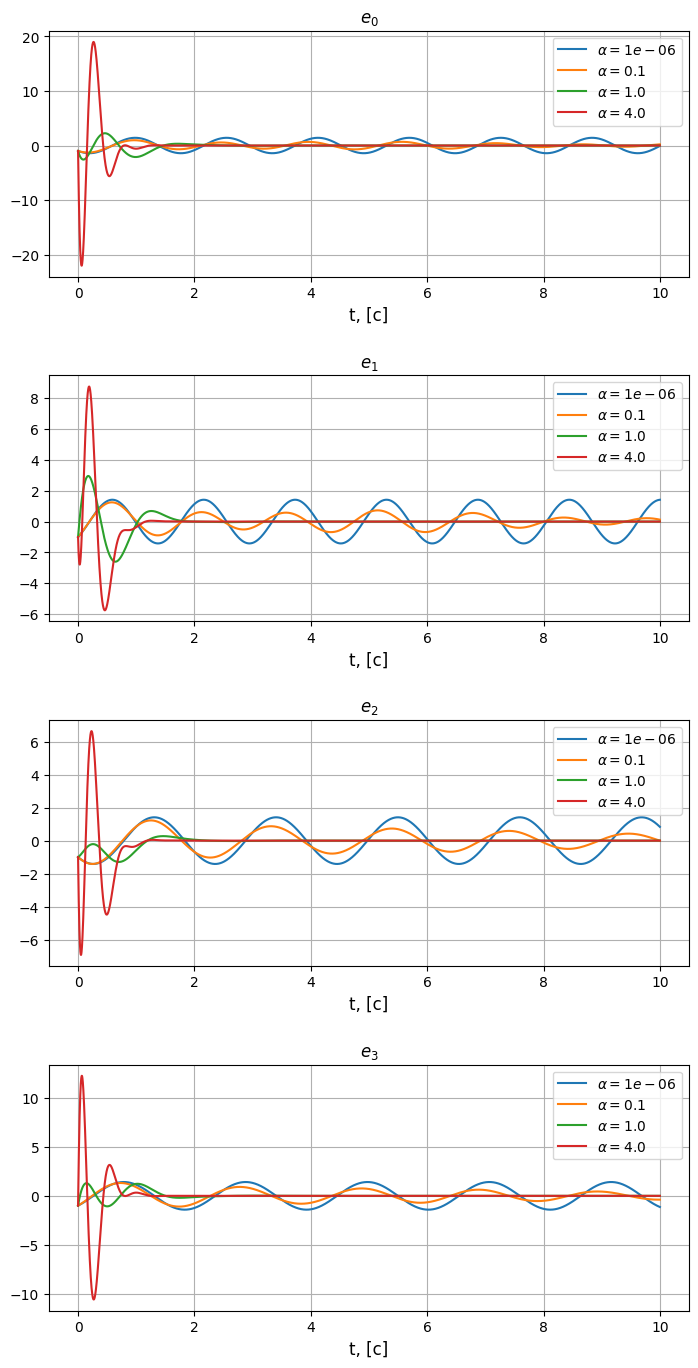

In [80]:
fig, axs = plt.subplots(4, figsize=(8, 16))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for indx, key in enumerate(task3_reses):
    (orig, obs), L = task3_reses[key]
    alpha = key
    for i, state in enumerate(obs.states):
        axs[i].plot(ts, orig.states[i] - obs.states[i], label=f"$\\alpha={alpha}$") 
    # break
for i in range(4):
    axs[i].set_xlabel(f"t, [c]", fontsize=12)
    axs[i].set_title(f"$e_{i}$", fontsize=12)
    axs[i].grid(True)
    axs[i].legend()

# Задание 4

In [85]:
task4_A = np.array([
    [5, -5, -9, 3],
    [-5, 5, -3, 9],
    [-9, -3, 5, 5],
    [3, 9, 5, 5]
])

task4_B = np.array([
    [2], 
    [6], 
    [6], 
    [2]
])

task4_C = (np.array([
    [1, -1, 1, 1],
    [1, 3, -1, 3]
]))

task4_alphas = [0.1, 1, 10]

check_observability_eigens(task4_C, task4_A)
check_controllability_eigens(task4_A, task4_B)

Eigen values of A:
   [-12.]: not observable
   [4.]: observable
   [16.]: observable
   [12.]: observable
Eigen values of A:
   [-12.]: controllable
   [4.]: controllable
   [16.]: controllable
   [12.]: controllable


In [91]:
def task4_get_e(alpha, ts):
    print(f'---------- {alpha} -------------')
    K, _ = task1_get_K(task4_A, task4_B, alpha)
    L, _ = task3_get_L(task4_A, task4_C, alpha)
    print(f"K: \n{K}")
    print(f"L.T: \n{L.T}")
    task4_new_A = np.block([[task4_A + task4_B @ K, -task4_B @ K], [np.zeros((task4_A.shape[0], K.shape[1] * 2 - task4_C.shape[1])), task4_A + L @ task4_C]])

    ss = control.ss(task4_new_A, task4_new_A * 0, task4_new_A * 0, task4_new_A * 0)
    res = control.forced_response(ss, T=ts, X0= 10 * np.ones((task3_A.shape[0]*2)))
    x = res.states[:4]
    e = res.states[4:]
    return e

    fig, axs = plt.subplots(2, 2, figsize=(8, 5))
    fig.suptitle(f'$\\alpha$ = {alpha}, max(e) = {np.max(e) : .1f}')
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(x.shape[0]):
        # axs[i//2, i % 2].plot(ts, x[i], color='r', linewidth=4, label='system')
        # axs[i//2, i % 2].plot(ts, xh[i], '--', color='g', linewidth = 2, label='observer')
        axs[i//2, i % 2].plot(ts, e[i], linewidth = 2, label='error')
        axs[i//2, i % 2].set_title(f'$x_{i} = x_{i}(t)$', fontsize=12)
        axs[i//2, i % 2].set_xlabel(f"t, [c]", fontsize=12)
        axs[i//2, i % 2].grid(True)
        axs[i//2, i % 2].legend()

---------- 0.1 -------------
Optimization error: 0.0
spec(P): [2.71e+04 2.26e+04 3.41e+00 1.72e+03]; P >> 0: True
spec(lmi): [  -141.74  -4706.03 -10594.69 -11171.42]; lyapunov_lmi <<= 0: True
[[ 6593.45  5002.28  5763.76 -6433.33]
 [ 5002.28  8814.36  8865.79  -574.77]
 [ 5763.76  8865.79 11324.33  3999.87]
 [-6433.33  -574.77  3999.87 24720.27]]
Optimization error: 0.0
spec(P): [4.39e+09 1.28e+08 7.36e+06 9.40e+06]; Q >> 0: True
spec(lmi): [-1.17e+09 -7.77e+07 -5.63e+04 -2.68e+05]; lyapunov_lmi <<= 0: True
K: 
[[ 159.98  100.26 -185.16   71.37]]
L.T: 
[[-18.84  -2.76 -18.84   2.76]
 [ 54.24 -23.47 -54.24 -23.47]]
---------- 1 -------------
Optimization error: 0.0
spec(P): [2.36e+04 1.99e+04 1.04e+03 2.88e+00]; P >> 0: True
spec(lmi): [  -64.81 -3238.29 -8873.02 -9576.64]; lyapunov_lmi <<= 0: True
[[ 6051.87  4958.96  5318.43 -6317.34]
 [ 4958.96  8151.56  8356.26  -892.56]
 [ 5318.43  8356.26  9965.43  2208.38]
 [-6317.34  -892.56  2208.38 20354.22]]
Optimization error: 0.0
spec(P): 

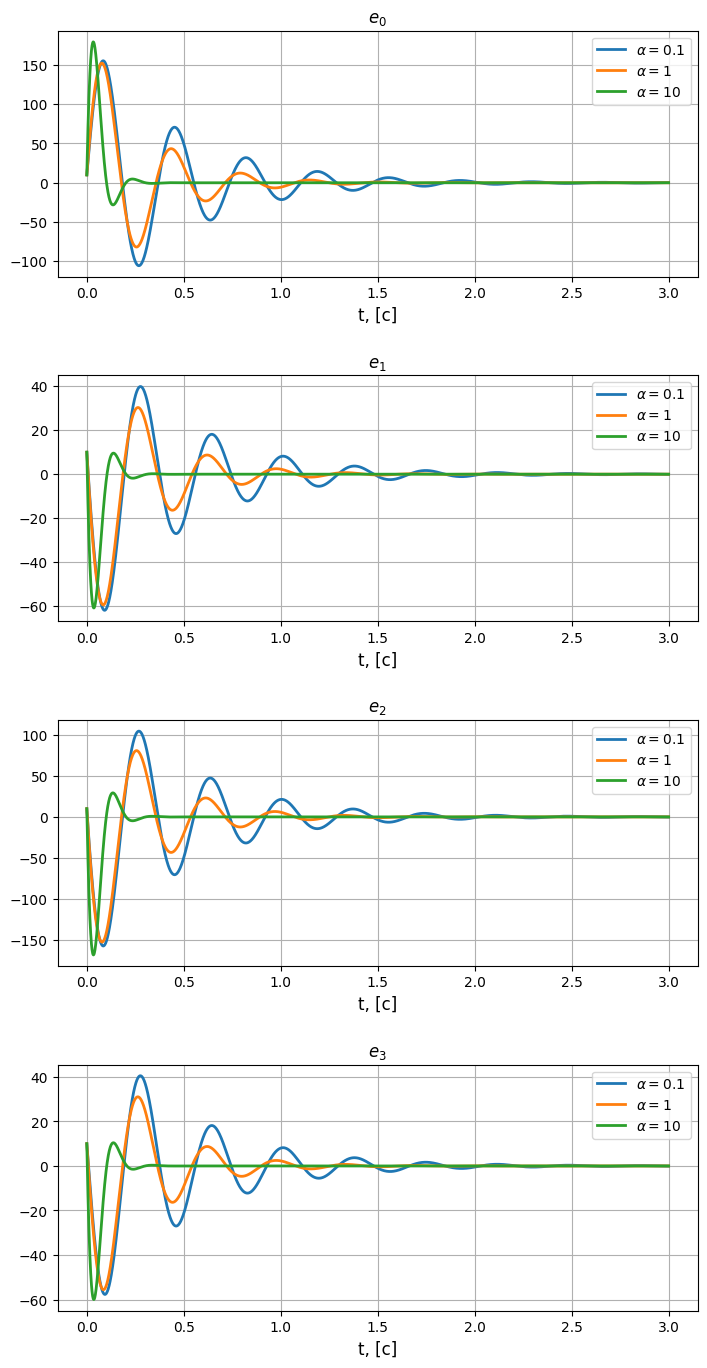

In [94]:
fig, axs = plt.subplots(4, figsize=(8, 16))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

ts = get_t(3)
for task4_alpha in task4_alphas:
    es = task4_get_e(task4_alpha, ts)
    for i in range(es.shape[0]):
        # axs[i//2, i % 2].plot(ts, x[i], color='r', linewidth=4, label='system')
        # axs[i//2, i % 2].plot(ts, xh[i], '--', color='g', linewidth = 2, label='observer')
        axs[i].plot(ts, es[i], linewidth = 2, label=f"$\\alpha = {task4_alpha}$")
        axs[i].set_title(f'$e_{i}$', fontsize=12)
        axs[i].set_xlabel(f"t, [c]", fontsize=12)
        axs[i].grid(True)
        axs[i].legend()